## This hackathon focused on creating visionary hacks so I decided to look at crime reports at UVA. I ultimately wanted to create an algorithm that could predict locations of where crime would happen. Unfortunately I didn't have enough time to implement that so I stuck with clustering the data of police reports, onto a latitude and longitude map

In [10]:
# Common imports
%matplotlib inline
import matplotlib as mpl
import numpy as np
import os
import pandas as pd

# You might want to use the following packages
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix # optional
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

#Reading data on speed limits for each road in VA
report = pd.read_csv("/Users/ladmin/Hackathons/WICS_Hack/University_of_Virginia.csv")
report.head()

,incident_id,case_number,incident_datetime,incident_type_primary,incident_description,clearance_type,address_1,address_2,city,state,...,country,latitude,longitude,created_at,updated_at,location,hour_of_day,day_of_week,parent_incident_type,University of Virginia Public Engines Shapes - srfu-ji83
0,829424782,2016-00000240,3/2/16 14:04,THEFT FROM BUILDING,THEFT FROM BUILDING,NaN,100 Block MCCORMICK RD,NaN,CHARLOTTESVILLE,VA,...,NaN,38.036695,-78.505187,12/20/17 18:23,12/20/17 22:16,POINT (-78.50518699999999 38.0366948),14,Wednesday,Theft,361237.0
1,829424633,2016-00000242,3/3/16 6:15,BURGLARY/B&E,BURGLARY/B&E,NaN,200 Block HEREFORD DR,NaN,CHARLOTTESVILLE,VA,...,NaN,38.028964,-78.519491,12/20/17 18:23,12/20/17 22:16,POINT (-78.5194913 38.0289641),6,Thursday,Breaking & Entering,NaN
2,829425277,2016-00000260,3/7/16 11:33,DISORDERLY CONDUCT,DISORDERLY CONDUCT,NaN,1200 Block LEE ST,NaN,CHARLOTTESVILLE,VA,...,NaN,38.031185,-78.498823,12/20/17 18:23,12/20/17 22:16,POINT (-78.4988225 38.0311849),11,Monday,Disorder,NaN
3,829424773,2016-00000263,3/7/16 18:00,THEFT FROM BUILDING,THEFT FROM BUILDING,NaN,1300 Block LEE ST,NaN,CHARLOTTESVILLE,VA,...,NaN,38.031364,-78.498920,12/20/17 18:23,12/20/17 22:16,POINT (-78.4989202 38.0313639),18,Monday,Theft,NaN
4,829425578,2016-00000266,3/8/16 19:45,TRESPASS ON REAL PROPERTY,TRESPASS ON REAL PROPERTY,NaN,400 Block MCCORMICK ROAD,NaN,CHARLOTTESVILLE,VA,...,NaN,38.034186,-78.512805,12/20/17 18:23,12/20/17 22:16,POINT (-78.5128051 38.0341859),19,Tuesday,Property Crime,361237.0


## I realized that there are only a specific amount of features that students and residents would care about. These are types of crime, date in which the time occurred, and the location of the crime. So I decided to drop the rest of the features and train the remaining ones

In [11]:
report = report.drop("country", axis = 1)
report = report.drop("clearance_type", axis = 1)
report = report.drop("address_2", axis = 1)
report = report.drop("University of Virginia Public Engines Shapes - srfu-ji83", axis = 1)
report = report.drop("incident_description", axis = 1)
report = report.drop("location", axis = 1)
report = report.drop("incident_id", axis = 1)
report = report.drop("case_number", axis = 1)
report = report.drop("address_1", axis = 1)
report = report.drop("city", axis = 1)
report = report.drop("state", axis = 1)
report = report.drop("zip", axis = 1)
report = report.drop("created_at", axis = 1)
report = report.drop("updated_at", axis = 1)

## Transforming the date text into milliseconds so the dates can be processed easier

In [12]:
from datetime import datetime

datetime_object = datetime.strptime(report["incident_datetime"][0], "%m/%d/%y %H:%M")

In [13]:
'{:%Y-%m}'.format(datetime.strptime('2016-07-31', '%Y-%m-%d'))

'2016-07'

In [14]:
for i in report.index:
    #Should check all unique values, because there's a few cells that don't start with Original Route Alias
    #datetime_object = datetime.strptime(report.at[i,"incident_datetime"], "%m/%d/%y %H:%M")
    datetime_object = '{:%m-%Y}'.format(datetime.strptime(report.at[i,"incident_datetime"], "%m/%d/%y %H:%M"))
    datetime_object = datetime.strptime(datetime_object, "%m-%Y")
    timestamp = datetime.timestamp(datetime_object)
    report.at[i,"incident_datetime"] = timestamp

In [15]:
report.head()

,incident_datetime,incident_type_primary,latitude,longitude,hour_of_day,day_of_week,parent_incident_type
0,1.45681e+09,THEFT FROM BUILDING,38.036695,-78.505187,14,Wednesday,Theft
1,1.45681e+09,BURGLARY/B&E,38.028964,-78.519491,6,Thursday,Breaking & Entering
2,1.45681e+09,DISORDERLY CONDUCT,38.031185,-78.498823,11,Monday,Disorder
3,1.45681e+09,THEFT FROM BUILDING,38.031364,-78.498920,18,Monday,Theft
4,1.45681e+09,TRESPASS ON REAL PROPERTY,38.034186,-78.512805,19,Tuesday,Property Crime


In [16]:
len(report)

1195

In [17]:
report["parent_incident_type"].value_counts()

Theft                   474
Assault                 273
Property Crime          142
Drugs                   134
Theft from Vehicle       55
Breaking & Entering      49
Disorder                 45
Theft of Vehicle         13
Kidnapping                4
Other Sexual Offense      3
Robbery                   2
Arson                     1
Name: parent_incident_type, dtype: int64

In [18]:
report["day_of_week"].value_counts()

Friday       207
Wednesday    183
Tuesday      177
Monday       174
Thursday     171
Saturday     144
Sunday       139
Name: day_of_week, dtype: int64

## Here I drop instances in types of crime in which there are very few frequencies. There were very few arson, robbery, and obscene crimes so I had to drop them in order to prevent them from skewing the model

In [19]:
# index_list = []

for i in report.index:
    if (report.at[i,"incident_type_primary"].find("ARSON") != -1):
        find = report.at[i,"incident_type_primary"].find("ARSON")
        print(find)
        print(i)
        report = report.drop(i)
        #index_list.append(i)
    elif (report.at[i,"incident_type_primary"].find("ROBBERY") != -1):
        find = report.at[i,"incident_type_primary"].find("ROBBERY")
        print(find)
        print(i)
        report = report.drop(i)
        #index_list.append(i)
    elif (report.at[i,"incident_type_primary"].find("PORNOGRAPHY/OBSCENE MATERIAL") != -1):
        find = report.at[i,"incident_type_primary"].find("PORNOGRAPHY/OBSCENE MATERIAL")
        if(find == 0):
            print(find)
            print(i)
            report = report.drop(i)
            #index_list.append(i)
    else:
        pass
        

0
151
0
265
0
296
0
301
0
609
0
878


In [20]:
report.head()

,incident_datetime,incident_type_primary,latitude,longitude,hour_of_day,day_of_week,parent_incident_type
0,1.45681e+09,THEFT FROM BUILDING,38.036695,-78.505187,14,Wednesday,Theft
1,1.45681e+09,BURGLARY/B&E,38.028964,-78.519491,6,Thursday,Breaking & Entering
2,1.45681e+09,DISORDERLY CONDUCT,38.031185,-78.498823,11,Monday,Disorder
3,1.45681e+09,THEFT FROM BUILDING,38.031364,-78.498920,18,Monday,Theft
4,1.45681e+09,TRESPASS ON REAL PROPERTY,38.034186,-78.512805,19,Tuesday,Property Crime


## Here I create two separate training sets, for longitude and latitude pairs 

In [24]:
long_x = report.drop('longitude', axis = 1)
long_y = report['longitude']
# X_train, X_test, y_train, y_test = train_test_split(rep_x, rep_y, shuffle = True, stratify=rep_y, test_size=0.20)
long_X_train, long_X_test, long_y_train, long_y_test = train_test_split(long_x, long_y, test_size=0.20)

In [25]:
lat_x = report.drop('latitude', axis = 1)
lat_y = report['latitude']
# X_train, X_test, y_train, y_test = train_test_split(rep_x, rep_y, shuffle = True, stratify=rep_y, test_size=0.20)
lat_X_train, lat_X_test, lat_y_train, lat_y_test = train_test_split(lat_x, lat_y, test_size=0.20)

In [26]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

cat_attribs = ['incident_type_primary', 'parent_incident_type', 'day_of_week']
#'Building Number', 'State'
full_pipeline = ColumnTransformer([
        #("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

In [27]:
long_X_train = full_pipeline.fit_transform(long_X_train)
long_X_test = full_pipeline.transform(long_X_test)

In [28]:
lat_X_train = full_pipeline.fit_transform(lat_X_train)
lat_X_test = full_pipeline.transform(lat_X_test)

## Here the RMSEs are really small, could be a symptom of overfitting

In [35]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import SGDRegressor
mySGDModel = SGDRegressor()
mySGDModel.fit(lat_X_train, lat_y_train)
y_lat = mySGDModel.predict(lat_X_test)
mse = mean_squared_error(lat_y_test, y_lat)
mySGDModel_rmse = np.sqrt(mse)
print("SGD RMSE: " + str(mySGDModel_rmse))

mySGDModel.fit(lat_X_train, lat_y_train)
y_long = mySGDModel.predict(lat_X_test)
mse = mean_squared_error(long_y_test, y_long)
mySGDModel_rmse = np.sqrt(mse)
print("SGD RMSE: " + str(mySGDModel_rmse))

SGD RMSE: 5.848983720315143
SGD RMSE: 114.30583863706933


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


In [36]:
coord = []
coord.append(y_lat.T)
coord.append(y_long.T)

In [39]:
coord

[array([16.36817748, 36.41066271, 15.52873515, 38.47558537, 39.55656444,
        28.4560591 , 39.48398054, 39.01769328, 38.68428462, 38.12762671,
        12.67022302, 24.50427729, 38.31090524, 35.31838986, 34.9249108 ,
        38.79020136, 35.6109668 , 35.48306998, 26.55713662, 37.91742619,
        38.12762671, 12.48694448, 39.55656444, 25.79077354, 36.56404905,
        38.31090524, 36.56404905, 38.14491811, 39.55656444, 37.84484229,
        38.98436044, 39.55656444, 38.31090524, 38.47558537, 26.55713662,
        35.13511132, 38.71761746, 38.23832135, 38.14491811, 39.48398054,
        27.21039991, 38.70307729, 27.02712138, 38.35511863, 38.98436044,
        38.71761746, 17.1678734 , 39.01769328, 39.78405636, 38.40300147,
        35.48306998, 26.6960318 , 38.98436044, 38.05504281, 38.35511863,
        38.35511863, 35.16500352, 30.47731172, 35.32968364, 24.15631863,
        35.48306998, 38.31090524, 38.40300147, 34.77152446, 35.6109668 ,
        38.70307729, 38.98436044, 35.13511132, 38.7

In [44]:
df1 = pd.DataFrame(y_long)
df2 = pd.DataFrame(y_lat)

In [47]:
df3 = pd.concat([df1, df2], axis = 1)
df3.columns = ["longitude", "latitude"]

## In the end I was not able to obtain locations of crimes in the way I wanted to. Instead the graph just shows a straight linear line. I think this could have been solved by making sure the data that gets splitted was the same in both latitude and longitude pairs.

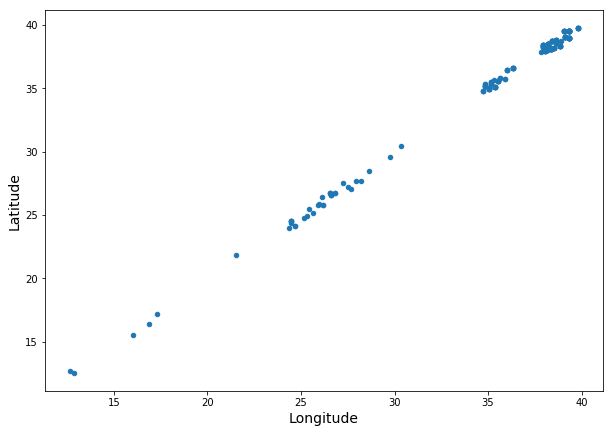

In [48]:
# Your code goes here
import matplotlib.pyplot as plt
ax = df3.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                       #s=df3['population']/100, label="Population",
                       #c="regions", cmap=plt.get_cmap("jet"),
                       #colorbar=True, alpha=0.4,
                      )
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.show()

# Your paragraph goes here for this section